# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import Shrec17DeepSphere as shrecDataset
from SHREC17.load_shrec import fix_dataset

## 0.2 Define parameters

In [5]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [6]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [7]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [8]:
download = False
train_dataset = shrecDataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=-1)


31363it [00:24, 1283.59it/s]


In [9]:
val_dataset = shrecDataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=-1)

5132it [00:03, 1283.16it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [10]:
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

Number of elements / class
  Training set: 
    Class 0: 2474 elements
    Class 1: 205 elements
    Class 2: 52 elements
    Class 3: 65 elements
    Class 4: 535 elements
    Class 5: 146 elements
    Class 6: 1124 elements
    Class 7: 45 elements
    Class 8: 266 elements
    Class 9: 286 elements
    Class 10: 104 elements
    Class 11: 553 elements
    Class 12: 935 elements
    Class 13: 67 elements
    Class 14: 64 elements
    Class 15: 34 elements
    Class 16: 2186 elements
    Class 17: 350 elements
    Class 18: 4050 elements
    Class 19: 402 elements
    Class 20: 42 elements
    Class 21: 56 elements
    Class 22: 674 elements
    Class 23: 43 elements
    Class 24: 459 elements
    Class 25: 186 elements
    Class 26: 492 elements
    Class 27: 102 elements
    Class 28: 335 elements
    Class 29: 259 elements
    Class 30: 1413 elements
    Class 31: 273 elements
    Class 32: 979 elements
    Class 33: 57 elements
    Class 34: 44 elements
    Class 35: 84 elements
 

In [11]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
#ids = train_dataset.retrieve_ids()
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31363 
first id: 005722


In [12]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [13]:
im1 = x_train[0,:,:2]
im0003 = train_dataset.data[0,:,:2]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = min(np.min(im1), np.min(im0003))
cmax = max(np.max(im1), np.max(im0003))

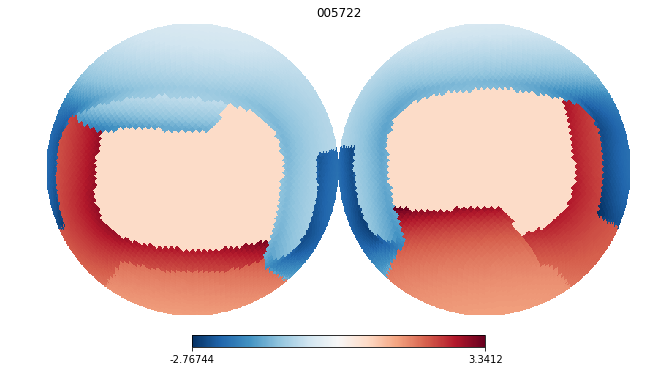

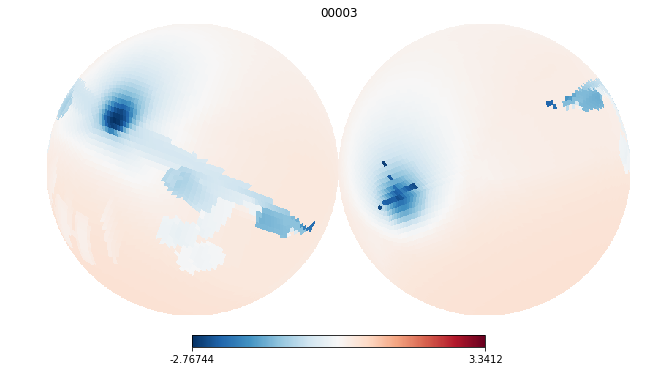

In [16]:
hp.orthview(im1[:,0], title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003[:0], rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
hp.orthview(im1[:,1], title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003[:,1], rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [17]:
#training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [18]:
EXP_NAME = 'shrec17_Cohen_simple_reg_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

In [45]:
params = hyperparameters.get_params_shrec17(training.N, EXP_NAME, Nside, train_dataset.nclass, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 8, 4]
#pixels: [12288, 768, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 7,707,770,880
Learning rate will start at 2.0e-02 and finish at 4.0e-04.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 1 * 100 * 56 = 5600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [20]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: fc1
    representation: M_4 = 64
    weights: M_3 * M_4 = 12288 * 64 = 786432
    biases: M_4 = 64
  layer 5: logits (softmax)
    representation: M_5 = 55
    weights: M_4 * M_5 = 64 * 55 = 3520
step 39 / 15681 (epoch 0.05 / 20):
  learning_rate = 1.06e-06, training loss = 4.19e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 4.89 (307 / 6273), f1 (weighted): 5.03, loss: 4.33e+00
  CPU time: 29s, wall time: 28s
step 78 / 15681 (epoch 0.10 / 20):
  learning_rate = 1.12e-06, training loss = 3.98e+00
  validation accuracy: 12.47 (782 / 6273), f1 (weighted): 7.80, loss: 4.15e+00
  CPU time: 49s, wall time: 48s
step 117 / 15681 (epoch 0.15 / 20):
  learning_rate = 1.19e-06, training loss = 4.41e+00
  validation accuracy: 16.01 (1004 / 6273), f1 (weighted): 7.20, loss: 4.01e+00
  CPU time: 67s, wall time: 65s
step 156 / 15681 (epoch 0.20 / 20):
  learning_rate = 1.26e-06, training loss = 3.97e+00
  validation accuracy: 16.40 (1029 / 6273), f1 (weighted): 6.67, loss: 3.91e+00
  CPU time: 85s, wall time: 83s
step 195 / 15681 (epoch 0.25 / 20):
  learning_rate = 1.33e-06, training loss = 3.93e+00
  validation accuracy: 16.36 (1026 / 6273), f1 (weighted): 6.12, loss: 3.84e+00
  CPU time: 103s, wall time: 100s
step 234 / 15681 (epoch 0.30 / 20):
  learning_rate = 1.41e-06, training loss = 4.38e+

step 1638 / 15681 (epoch 2.09 / 20):
  learning_rate = 1.11e-05, training loss = 2.17e+00
  validation accuracy: 50.57 (3172 / 6273), f1 (weighted): 42.68, loss: 2.39e+00
  CPU time: 767s, wall time: 741s
step 1677 / 15681 (epoch 2.14 / 20):
  learning_rate = 1.17e-05, training loss = 2.68e+00
  validation accuracy: 50.41 (3162 / 6273), f1 (weighted): 42.42, loss: 2.37e+00
  CPU time: 785s, wall time: 758s
step 1716 / 15681 (epoch 2.19 / 20):
  learning_rate = 1.24e-05, training loss = 2.48e+00
  validation accuracy: 52.05 (3265 / 6273), f1 (weighted): 44.01, loss: 2.33e+00
  CPU time: 804s, wall time: 776s
step 1755 / 15681 (epoch 2.24 / 20):
  learning_rate = 1.31e-05, training loss = 2.64e+00
  validation accuracy: 52.67 (3304 / 6273), f1 (weighted): 45.51, loss: 2.30e+00
  CPU time: 822s, wall time: 793s
step 1794 / 15681 (epoch 2.29 / 20):
  learning_rate = 1.39e-05, training loss = 2.37e+00
  validation accuracy: 52.40 (3287 / 6273), f1 (weighted): 44.62, loss: 2.28e+00
  CPU tim

step 3198 / 15681 (epoch 4.08 / 20):
  learning_rate = 1.09e-04, training loss = 1.74e+00
  validation accuracy: 61.12 (3834 / 6273), f1 (weighted): 57.30, loss: 1.79e+00
  CPU time: 1488s, wall time: 1437s
step 3237 / 15681 (epoch 4.13 / 20):
  learning_rate = 1.16e-04, training loss = 1.59e+00
  validation accuracy: 60.48 (3794 / 6273), f1 (weighted): 55.63, loss: 1.84e+00
  CPU time: 1506s, wall time: 1454s
step 3276 / 15681 (epoch 4.18 / 20):
  learning_rate = 1.23e-04, training loss = 1.32e+00
  validation accuracy: 59.45 (3729 / 6273), f1 (weighted): 55.93, loss: 1.82e+00
  CPU time: 1524s, wall time: 1472s
step 3315 / 15681 (epoch 4.23 / 20):
  learning_rate = 1.30e-04, training loss = 1.84e+00
  validation accuracy: 60.43 (3791 / 6273), f1 (weighted): 57.21, loss: 1.80e+00
  CPU time: 1542s, wall time: 1489s
step 3354 / 15681 (epoch 4.28 / 20):
  learning_rate = 1.38e-04, training loss = 1.33e+00
  validation accuracy: 60.64 (3804 / 6273), f1 (weighted): 56.91, loss: 1.82e+00
 

step 4758 / 15681 (epoch 6.07 / 20):
  learning_rate = 1.08e-03, training loss = 1.52e+00
  validation accuracy: 64.36 (4037 / 6273), f1 (weighted): 60.36, loss: 1.88e+00
  CPU time: 2208s, wall time: 2131s
step 4797 / 15681 (epoch 6.12 / 20):
  learning_rate = 1.14e-03, training loss = 2.07e+00
  validation accuracy: 59.00 (3701 / 6273), f1 (weighted): 55.80, loss: 2.03e+00
  CPU time: 2225s, wall time: 2148s
step 4836 / 15681 (epoch 6.17 / 20):
  learning_rate = 1.21e-03, training loss = 2.50e+00
  validation accuracy: 63.30 (3971 / 6273), f1 (weighted): 59.74, loss: 1.92e+00
  CPU time: 2243s, wall time: 2166s
step 4875 / 15681 (epoch 6.22 / 20):
  learning_rate = 1.28e-03, training loss = 1.73e+00
  validation accuracy: 60.90 (3820 / 6273), f1 (weighted): 59.43, loss: 2.03e+00
  CPU time: 2261s, wall time: 2183s
step 4914 / 15681 (epoch 6.27 / 20):
  learning_rate = 1.36e-03, training loss = 2.04e+00
  validation accuracy: 59.03 (3703 / 6273), f1 (weighted): 57.28, loss: 2.17e+00
 

step 6318 / 15681 (epoch 8.06 / 20):
  learning_rate = 1.07e-02, training loss = 5.22e+00
  validation accuracy: 49.66 (3115 / 6273), f1 (weighted): 45.46, loss: 6.09e+00
  CPU time: 2925s, wall time: 2824s
step 6357 / 15681 (epoch 8.11 / 20):
  learning_rate = 1.13e-02, training loss = 5.31e+00
  validation accuracy: 51.12 (3207 / 6273), f1 (weighted): 46.60, loss: 6.38e+00
  CPU time: 2943s, wall time: 2841s
step 6396 / 15681 (epoch 8.16 / 20):
  learning_rate = 1.20e-02, training loss = 5.49e+00
  validation accuracy: 47.20 (2961 / 6273), f1 (weighted): 45.42, loss: 6.79e+00
  CPU time: 2961s, wall time: 2859s
step 6435 / 15681 (epoch 8.21 / 20):
  learning_rate = 1.27e-02, training loss = 4.92e+00
  validation accuracy: 47.03 (2950 / 6273), f1 (weighted): 45.79, loss: 6.28e+00
  CPU time: 2978s, wall time: 2876s
step 6474 / 15681 (epoch 8.26 / 20):
  learning_rate = 1.34e-02, training loss = 5.75e+00
  validation accuracy: 45.43 (2850 / 6273), f1 (weighted): 43.85, loss: 7.43e+00
 

step 7878 / 15681 (epoch 10.05 / 20):
  learning_rate = 1.06e-01, training loss = 1.67e+01
  validation accuracy: 25.94 (1627 / 6273), f1 (weighted): 23.16, loss: 1.99e+01
  CPU time: 3642s, wall time: 3516s
step 7917 / 15681 (epoch 10.10 / 20):
  learning_rate = 1.12e-01, training loss = 4.55e+01
  validation accuracy: 10.78 (676 / 6273), f1 (weighted): 8.44, loss: 5.43e+01
  CPU time: 3660s, wall time: 3533s
step 7956 / 15681 (epoch 10.15 / 20):
  learning_rate = 1.18e-01, training loss = 1.53e+01
  validation accuracy: 24.74 (1552 / 6273), f1 (weighted): 21.50, loss: 1.78e+01
  CPU time: 3678s, wall time: 3550s
step 7995 / 15681 (epoch 10.20 / 20):
  learning_rate = 1.25e-01, training loss = 1.68e+01
  validation accuracy: 20.60 (1292 / 6273), f1 (weighted): 20.42, loss: 1.94e+01
  CPU time: 3696s, wall time: 3568s
step 8034 / 15681 (epoch 10.25 / 20):
  learning_rate = 1.33e-01, training loss = 3.02e+01
  validation accuracy: 20.64 (1295 / 6273), f1 (weighted): 17.11, loss: 3.25e+0

step 9438 / 15681 (epoch 12.04 / 20):
  learning_rate = 1.04e+00, training loss = 2.03e+04
  validation accuracy: 10.43 (654 / 6273), f1 (weighted): 8.34, loss: 5.77e+04
  CPU time: 4360s, wall time: 4208s
step 9477 / 15681 (epoch 12.09 / 20):
  learning_rate = 1.10e+00, training loss = 2.35e+04
  validation accuracy: 7.83 (491 / 6273), f1 (weighted): 2.22, loss: 9.56e+04
  CPU time: 4378s, wall time: 4226s
step 9516 / 15681 (epoch 12.14 / 20):
  learning_rate = 1.17e+00, training loss = 2.57e+04
  validation accuracy: 5.44 (341 / 6273), f1 (weighted): 6.40, loss: 9.75e+04
  CPU time: 4396s, wall time: 4243s
step 9555 / 15681 (epoch 12.19 / 20):
  learning_rate = 1.24e+00, training loss = 2.61e+04
  validation accuracy: 10.97 (688 / 6273), f1 (weighted): 10.89, loss: 5.16e+04
  CPU time: 4414s, wall time: 4260s
step 9594 / 15681 (epoch 12.24 / 20):
  learning_rate = 1.31e+00, training loss = 2.45e+04
  validation accuracy: 5.74 (360 / 6273), f1 (weighted): 1.30, loss: 1.34e+05
  CPU ti

step 10998 / 15681 (epoch 14.03 / 20):
  learning_rate = 1.03e+01, training loss = 2.73e+05
  validation accuracy: 2.36 (148 / 6273), f1 (weighted): 2.10, loss: 9.40e+05
  CPU time: 5076s, wall time: 4899s
step 11037 / 15681 (epoch 14.08 / 20):
  learning_rate = 1.09e+01, training loss = 2.31e+08
  validation accuracy: 0.16 (10 / 6273), f1 (weighted): 0.00, loss: 4.11e+10
  CPU time: 5094s, wall time: 4916s
step 11076 / 15681 (epoch 14.13 / 20):
  learning_rate = 1.16e+01, training loss = 2.09e+10
  validation accuracy: 1.66 (104 / 6273), f1 (weighted): 0.05, loss: 1.91e+11
  CPU time: 5112s, wall time: 4934s
step 11115 / 15681 (epoch 14.18 / 20):
  learning_rate = 1.22e+01, training loss = 1.65e+10
  validation accuracy: 2.49 (156 / 6273), f1 (weighted): 0.12, loss: 3.22e+10
  CPU time: 5130s, wall time: 4951s
step 11154 / 15681 (epoch 14.23 / 20):
  learning_rate = 1.30e+01, training loss = 4.17e+09
  validation accuracy: 1.61 (101 / 6273), f1 (weighted): 0.08, loss: 9.27e+09
  CPU t

step 12558 / 15681 (epoch 16.02 / 20):
  learning_rate = 1.02e+02, training loss = 3.76e+11
  validation accuracy: 0.16 (10 / 6273), f1 (weighted): 0.00, loss: 4.57e+11
  CPU time: 5793s, wall time: 5591s
step 12597 / 15681 (epoch 16.07 / 20):
  learning_rate = 1.08e+02, training loss = 6.04e+11
  validation accuracy: 0.75 (47 / 6273), f1 (weighted): 0.01, loss: 1.04e+12
  CPU time: 5811s, wall time: 5608s
step 12636 / 15681 (epoch 16.12 / 20):
  learning_rate = 1.14e+02, training loss = 1.38e+12
  validation accuracy: 0.33 (21 / 6273), f1 (weighted): 0.00, loss: 2.42e+12
  CPU time: 5829s, wall time: 5626s
step 12675 / 15681 (epoch 16.17 / 20):
  learning_rate = 1.21e+02, training loss = 7.06e+12
  validation accuracy: 6.26 (393 / 6273), f1 (weighted): 0.74, loss: 6.42e+12
  CPU time: 5847s, wall time: 5643s
step 12714 / 15681 (epoch 16.22 / 20):
  learning_rate = 1.28e+02, training loss = 8.48e+12
  validation accuracy: 7.84 (492 / 6273), f1 (weighted): 1.14, loss: 8.15e+12
  CPU tim

step 14118 / 15681 (epoch 18.01 / 20):
  learning_rate = 1.01e+03, training loss = 1.37e+15
  validation accuracy: 1.48 (93 / 6273), f1 (weighted): 0.04, loss: 1.40e+15
  CPU time: 6512s, wall time: 6285s
step 14157 / 15681 (epoch 18.06 / 20):
  learning_rate = 1.07e+03, training loss = 2.13e+15
  validation accuracy: 1.45 (91 / 6273), f1 (weighted): 0.04, loss: 1.55e+15
  CPU time: 6530s, wall time: 6302s
step 14196 / 15681 (epoch 18.11 / 20):
  learning_rate = 1.13e+03, training loss = 5.55e+14
  validation accuracy: 1.66 (104 / 6273), f1 (weighted): 0.05, loss: 1.50e+15
  CPU time: 6549s, wall time: 6319s
step 14235 / 15681 (epoch 18.16 / 20):
  learning_rate = 1.19e+03, training loss = 3.72e+15
  validation accuracy: 0.45 (28 / 6273), f1 (weighted): 0.00, loss: 5.05e+15
  CPU time: 6566s, wall time: 6337s
step 14274 / 15681 (epoch 18.21 / 20):
  learning_rate = 1.27e+03, training loss = 8.68e+15
  validation accuracy: 16.01 (1004 / 6273), f1 (weighted): 4.42, loss: 6.74e+15
  CPU t

step 15678 / 15681 (epoch 20.00 / 20):
  learning_rate = 9.94e+03, training loss = 4.22e+18
  validation accuracy: 6.26 (393 / 6273), f1 (weighted): 0.74, loss: 2.95e+18
  CPU time: 7234s, wall time: 6982s
step 15681 / 15681 (epoch 20.00 / 20):
  learning_rate = 9.99e+03, training loss = 3.03e+18
  validation accuracy: 1.48 (93 / 6273), f1 (weighted): 0.04, loss: 3.34e+18
  CPU time: 7243s, wall time: 6989s
validation accuracy: best = 64.36, mean = 6.72


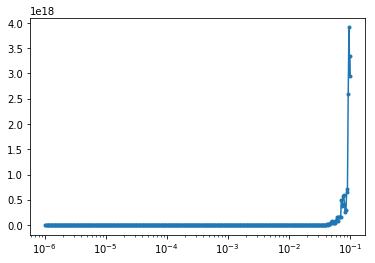

In [23]:
# backup = params.copy()

# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)

# params.update(backup)

# plt.semilogx(learning_rate, loss_validation, '.-')

## 2.2 Train Network

In [46]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

<tf.Variable 'conv1/weights:0' shape=(336, 100) dtype=float32_ref>
<tf.Variable 'conv1/bias:0' shape=(1, 1, 100) dtype=float32_ref>
<tf.Variable 'conv2/weights:0' shape=(1300, 100) dtype=float32_ref>
<tf.Variable 'conv2/bias:0' shape=(1, 1, 100) dtype=float32_ref>
<tf.Variable 'logits/weights:0' shape=(100, 55) dtype=float32_ref>
the number of parameters in the model is: 169,300


In [47]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 98 / 19601 (epoch 0.10 / 20):
  learning_rate = 1.92e-02, training loss = 2.03e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 50.33 (2583 / 5132), f1 (weighted): 43.80, loss: 2.74e+00
  CPU time: 80s, wall time: 120s
step 196 / 19601 (epoch 0.20 / 20):
  learning_rate = 1.85e-02, training loss = 2.03e+00
  validation accuracy: 48.11 (2469 / 5132), f1 (weighted): 42.23, loss: 2.86e+00
  CPU time: 153s, wall time: 233s
step 294 / 19601 (epoch 0.30 / 20):
  learning_rate = 1.78e-02, training loss = 1.94e+00
  validation accuracy: 51.38 (2637 / 5132), f1 (weighted): 45.30, loss: 2.54e+00
  CPU time: 225s, wall time: 346s
step 392 / 19601 (epoch 0.40 / 20):
  learning_rate = 1.71e-02, training loss = 2.21e+00
  validation accuracy: 52.49 (2694 / 5132), f1 (weighted): 47.76, loss: 2.56e+00
  CPU time: 299s, wall time: 460s
step 490 / 19601 (epoch 0.50 / 20):
  learning_rate = 1.64e-02, training loss = 2.37e+00
  validation accuracy: 55.03 (2824 / 5132), f1 (weighted): 50.53, loss: 2.35e+00
  CPU time: 372s, wall time: 574s
step 588 / 19601 (epoch 0.60 / 20):
  learning_rate = 1.58e-02, traini

  validation accuracy: 67.44 (3461 / 5132), f1 (weighted): 63.06, loss: 1.52e+00
  CPU time: 3021s, wall time: 4674s
step 4116 / 19601 (epoch 4.20 / 20):
  learning_rate = 3.85e-03, training loss = 1.33e+00
  validation accuracy: 66.29 (3402 / 5132), f1 (weighted): 63.15, loss: 1.51e+00
  CPU time: 3095s, wall time: 4788s
step 4214 / 19601 (epoch 4.30 / 20):
  learning_rate = 3.70e-03, training loss = 1.40e+00
  validation accuracy: 65.69 (3371 / 5132), f1 (weighted): 61.55, loss: 1.58e+00
  CPU time: 3169s, wall time: 4901s
step 4312 / 19601 (epoch 4.40 / 20):
  learning_rate = 3.56e-03, training loss = 1.69e+00
  validation accuracy: 66.31 (3403 / 5132), f1 (weighted): 61.94, loss: 1.52e+00
  CPU time: 3243s, wall time: 5016s
step 4410 / 19601 (epoch 4.50 / 20):
  learning_rate = 3.42e-03, training loss = 1.37e+00
  validation accuracy: 67.85 (3482 / 5132), f1 (weighted): 64.49, loss: 1.45e+00
  CPU time: 3317s, wall time: 5130s
step 4508 / 19601 (epoch 4.60 / 20):
  learning_rate = 

  validation accuracy: 69.97 (3591 / 5132), f1 (weighted): 66.76, loss: 1.33e+00
  CPU time: 5970s, wall time: 9233s
step 8036 / 19601 (epoch 8.20 / 20):
  learning_rate = 8.02e-04, training loss = 1.14e+00
  validation accuracy: 69.74 (3579 / 5132), f1 (weighted): 66.88, loss: 1.31e+00
  CPU time: 6044s, wall time: 9347s
step 8134 / 19601 (epoch 8.30 / 20):
  learning_rate = 7.72e-04, training loss = 1.50e+00
  validation accuracy: 70.56 (3621 / 5132), f1 (weighted): 67.10, loss: 1.32e+00
  CPU time: 6117s, wall time: 9461s
step 8232 / 19601 (epoch 8.40 / 20):
  learning_rate = 7.42e-04, training loss = 1.35e+00
  validation accuracy: 70.07 (3596 / 5132), f1 (weighted): 66.72, loss: 1.32e+00
  CPU time: 6191s, wall time: 9575s
step 8330 / 19601 (epoch 8.50 / 20):
  learning_rate = 7.13e-04, training loss = 1.01e+00
  validation accuracy: 70.05 (3595 / 5132), f1 (weighted): 66.95, loss: 1.30e+00
  CPU time: 6264s, wall time: 9688s
step 8428 / 19601 (epoch 8.60 / 20):
  learning_rate = 

step 11858 / 19601 (epoch 12.10 / 20):
  learning_rate = 1.74e-04, training loss = 1.45e+00
  validation accuracy: 71.30 (3659 / 5132), f1 (weighted): 68.33, loss: 1.25e+00
  CPU time: 8921s, wall time: 13801s
step 11956 / 19601 (epoch 12.20 / 20):
  learning_rate = 1.67e-04, training loss = 1.11e+00
  validation accuracy: 71.28 (3658 / 5132), f1 (weighted): 68.49, loss: 1.24e+00
  CPU time: 8995s, wall time: 13915s
step 12054 / 19601 (epoch 12.30 / 20):
  learning_rate = 1.61e-04, training loss = 1.40e+00
  validation accuracy: 71.36 (3662 / 5132), f1 (weighted): 68.44, loss: 1.25e+00
  CPU time: 9069s, wall time: 14029s
step 12152 / 19601 (epoch 12.40 / 20):
  learning_rate = 1.55e-04, training loss = 1.12e+00
  validation accuracy: 71.08 (3648 / 5132), f1 (weighted): 67.94, loss: 1.25e+00
  CPU time: 9142s, wall time: 14143s
step 12250 / 19601 (epoch 12.50 / 20):
  learning_rate = 1.49e-04, training loss = 8.92e-01
  validation accuracy: 71.02 (3645 / 5132), f1 (weighted): 68.07, lo

step 15680 / 19601 (epoch 16.00 / 20):
  learning_rate = 3.77e-05, training loss = 9.97e-01
  validation accuracy: 71.12 (3650 / 5132), f1 (weighted): 68.18, loss: 1.23e+00
  CPU time: 11807s, wall time: 18254s


KeyboardInterrupt: 

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

It seems that there is an overfit

In [48]:
predictions, loss = model.predict(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN/model-15680


In [49]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN/model-15680


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 71.12 (3650 / 5132), f1 (weighted): 68.18, loss: 1.23e+00\nCPU time: 45s, wall time: 41s',
 71.12236944660951,
 68.18342502191824,
 1.2319856247489376)

In [50]:
probabilities = model.probs(x_val, nclass)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN/model-15680


In [51]:
predictions = predictions.astype(np.int)

In [52]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results2/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results2/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

## test network

In [57]:
test_dataset = shrecDataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=-1)

10264it [00:11, 909.79it/s]


In [63]:
x_test, _, ids_test = test_dataset.return_data(train=False)

In [64]:
predictions = model.predict(x_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN/model-15680


In [65]:
probabilities = model.probs(x_test, nclass)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_32sides_0noise_CNN/model-15680


In [66]:
predictions = predictions.astype(np.int)

write to file

In [67]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results2/test_perturbed'), exist_ok=True)
for _id in ids_test:
    idfile = os.path.join(datapath,'results2/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))